In [1]:
!pip install split-folders

import os
import sys
import warnings
import tensorflow as tf
import keras
from keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dropout, Activation, MaxPooling2D, Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow import random as tf_random
import matplotlib.pyplot as plt
from matplotlib.image import imread
import numpy as np
from PIL import Image #for data preprocessing tasks
import random
import splitfolders
from tensorflow.keras.layers import BatchNormalization
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.regularizers import l2
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomContrast, RandomBrightness, Conv2D, AveragePooling2D, MaxPooling2D, Dropout, Flatten, Dense

2024-05-27 16:21:27.583635: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-27 16:21:27.583769: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-27 16:21:27.715042: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Let's define a function that we will use to plot the preformances

In [2]:
def performance(history):
    plt.figure(figsize=(12, 5))

    # Plot training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training')
    plt.plot(history.history['val_loss'], label = 'Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.grid(alpha=0.25)

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    plt.grid(alpha=0.25)

    plt.tight_layout()
    plt.show()

In [3]:
def custom_seed_set(seed_value=123):
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)

In [4]:
import os
import shutil
import random
from pathlib import Path

ds_path = '/kaggle/input/muffin-vs-chihuahua-image-classification'
original_train_path = os.path.join(ds_path, 'train')
original_test_path = os.path.join(ds_path, 'test')


new_base_path = '/kaggle/working/split_dataset'
new_train_path = os.path.join(new_base_path, 'train')
new_val_path = os.path.join(new_base_path, 'val')
new_test_path = os.path.join(new_base_path, 'test')

for path in [new_train_path, new_val_path, new_test_path]:
    for subfolder in ['chihuahua', 'muffin']:
        os.makedirs(os.path.join(path, subfolder), exist_ok=True)
        
def split_and_copy_images(src_path, train_path, val_path, test_path, split_ratio=(0.8, 0.1, 0.1)):
    for category in ['chihuahua', 'muffin']:
        category_path = os.path.join(src_path, category)
        images = os.listdir(category_path)
        
        random.shuffle(images)
        
        total_images = len(images)
        train_idx = int(total_images * split_ratio[0])
        val_idx = int(total_images * (split_ratio[0] + split_ratio[1]))
        
        train_images = images[:train_idx]
        val_images = images[train_idx:val_idx]
        test_images = images[val_idx:]
        
        for image in train_images:
            shutil.copy(os.path.join(category_path, image), os.path.join(train_path, category, image))
        
        for image in val_images:
            shutil.copy(os.path.join(category_path, image), os.path.join(val_path, category, image))
        
        for image in test_images:
            shutil.copy(os.path.join(category_path, image), os.path.join(test_path, category, image))


In [5]:
#Split and copy images from original train and test folders
split_and_copy_images(original_train_path, new_train_path, new_val_path, new_test_path)
split_and_copy_images(original_test_path, new_train_path, new_val_path, new_test_path)

In [6]:
#Verify the number of images in each set
for folder in ['train', 'val', 'test']:
    for category in ['chihuahua', 'muffin']:
        path = os.path.join(new_base_path, folder, category)
        print(f"{folder}->{category}: {len(os.listdir(path))} images")


train->chihuahua: 2559 images
train->muffin: 2174 images
val->chihuahua: 320 images
val->muffin: 271 images
test->chihuahua: 320 images
test->muffin: 273 images


In [7]:
data_path = '/kaggle/input/muffin-vs-chihuahua-image-classification'
base_dir = '/kaggle/working/split_dataset'
train_path = '/kaggle/working/split_dataset/train'
test_path = '/kaggle/working/split_dataset/test'
val_path = '/kaggle/working/split_dataset/val'

Let's now load images counting whether there are any corrupted ones.

In [8]:
def load_images(folder_path):
    images = []
    corrupted_images = 0
    for filename in os.listdir(folder_path):
        image_path = os.path.join(folder_path, filename)
        try:
            image = Image.open(image_path)
            images.append(image)
        except (IOError, OSError) as e:
            print(f"Corruption error: {image_path}({e})")
            corrupted_images += 1
    print(f"Number of corrupted images: {corrupted_images}")
    return images

In [9]:
train_m = load_images(os.path.join(train_path, 'muffin'))
train_c = load_images(os.path.join(train_path, 'chihuahua'))
val_m = load_images(os.path.join(val_path, 'muffin'))
val_c = load_images(os.path.join(val_path, 'chihuahua'))
test_m = load_images(os.path.join(test_path, 'muffin'))
test_c = load_images(os.path.join(test_path, 'chihuahua'))

Number of corrupted images: 0
Number of corrupted images: 0
Number of corrupted images: 0
Number of corrupted images: 0
Number of corrupted images: 0
Number of corrupted images: 0


There are no corruted images, we can use the entire dataset. We plot some of the images so as to have an idea about what we are dealing with.

In [10]:
p = '/kaggle/working'

In [11]:
def l_i(images, rows, cols, title, p=None, file_name='plot.png'):
    fig, ax = plt.subplots(rows, cols, figsize=(15,15))
    fig.suptitle(title)
    for j in range(rows):
        for i in range(cols):
            rnd_idx = random.randint(0, len(images) - 1)
            rnd_im = images[rnd_idx]
            ax[j, i].imshow(rnd_im)
            ax[j, i].axis('off')
    if p:
        os.makedirs(p, exist_ok=True)
        save_path = os.path.join(p, file_name)
        plt.savefig(save_path)

    plt.show()

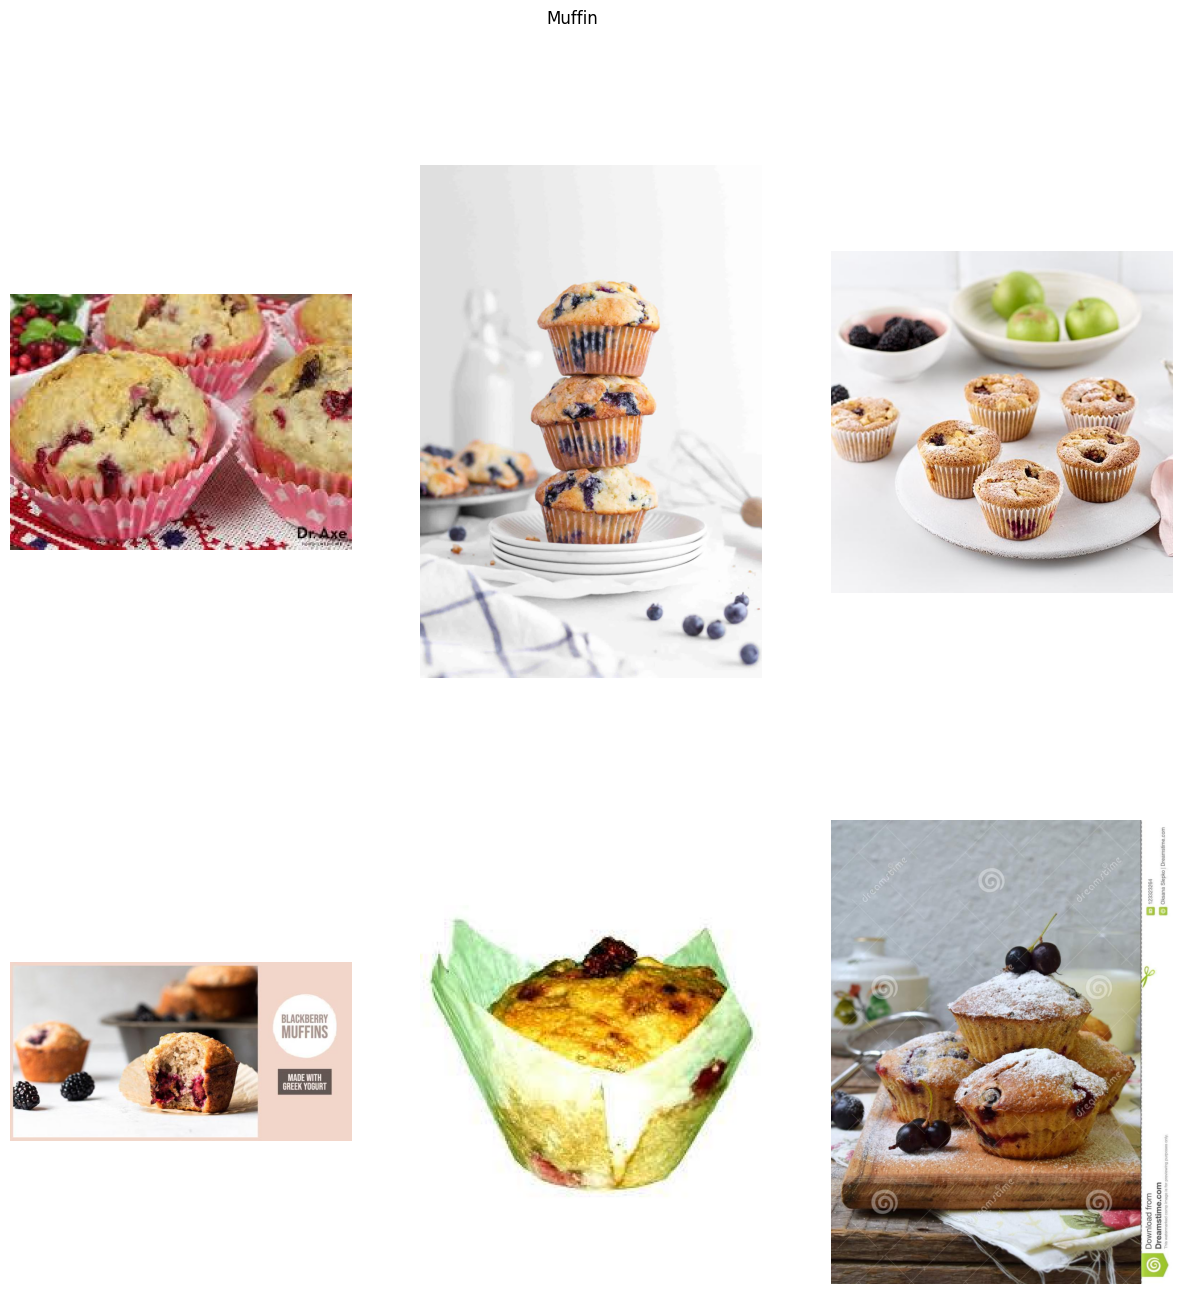

In [12]:
l_i(train_m, 2, 3, 'Muffin', p, 'muffin_plot.png')

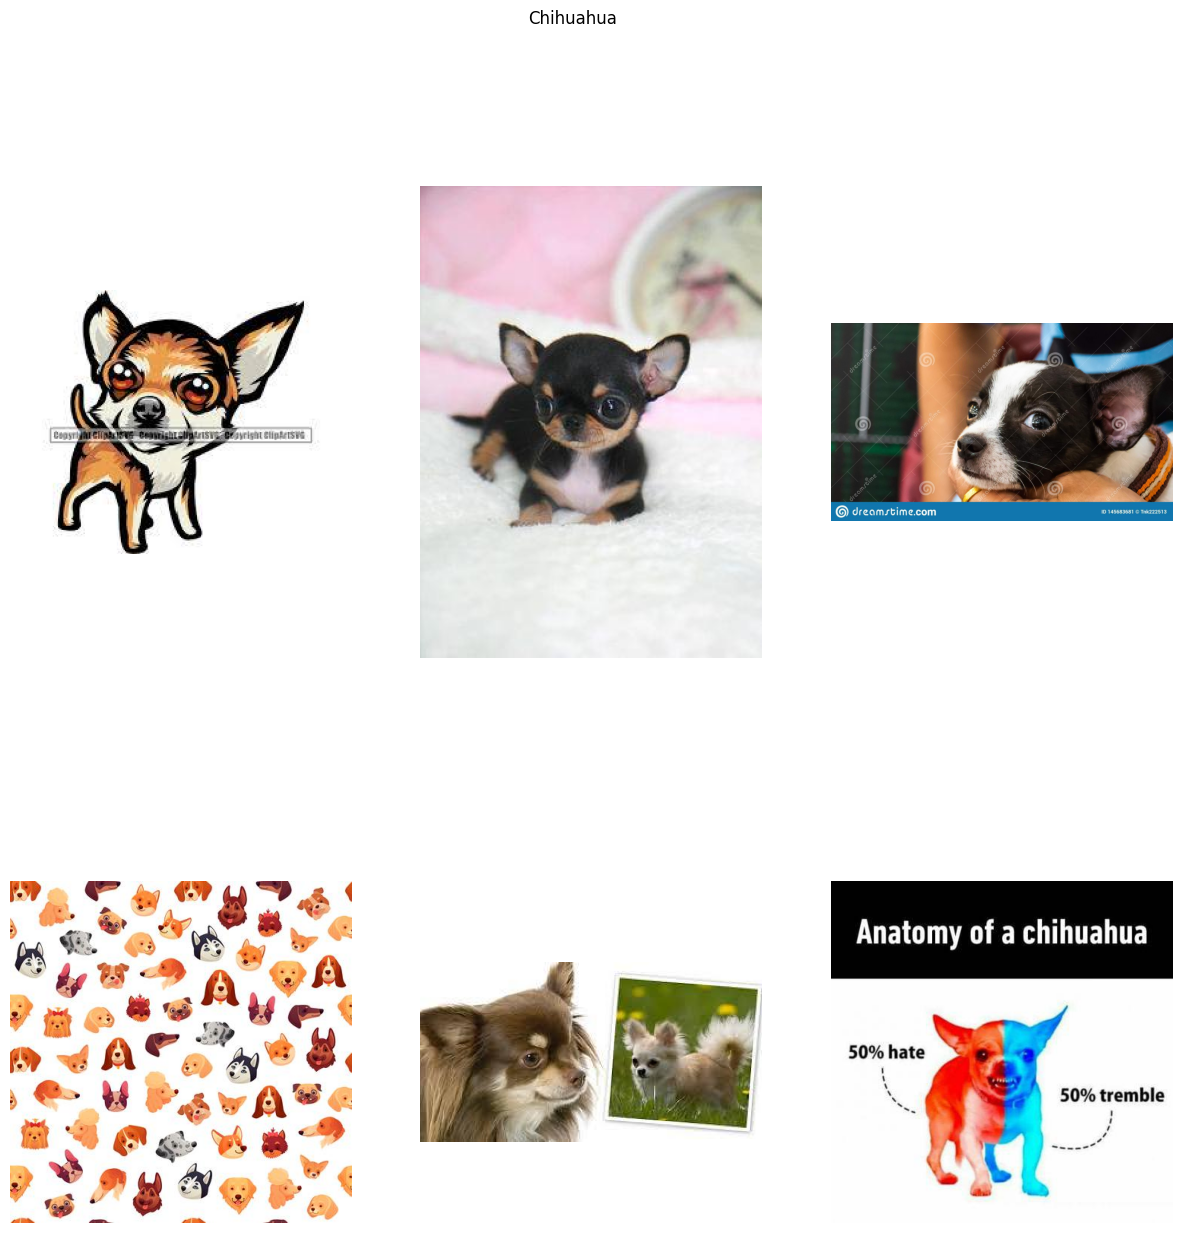

In [13]:
l_i(train_c, 2, 3, 'Chihuahua', p, 'chihuahua_plot.png')

We now assign labels and rescale the images while converting in gray scale

In [14]:
fix_size = 150
classes = {'chihuahua': 0, 'muffin': 1}

def rescale_gray(root_folder):
    data = []

    for class_name in classes:
        class_path = os.path.join(root_folder, class_name)
        label = classes[class_name]

        for filename in os.listdir(class_path):
            image_path = os.path.join(class_path, filename)
            gray = Image.open(image_path).convert('L')
            scaled = gray.resize((fix_size, fix_size))
            scaled_array = np.array(scaled)
            data.append([scaled, label])

    return data

In [15]:
train_data = rescale_gray(train_path)
val_data = rescale_gray(val_path)
test_data = rescale_gray(test_path)

In [16]:
print(len(train_data))
print(len(val_data))
print(len(test_data))

4733
591
593


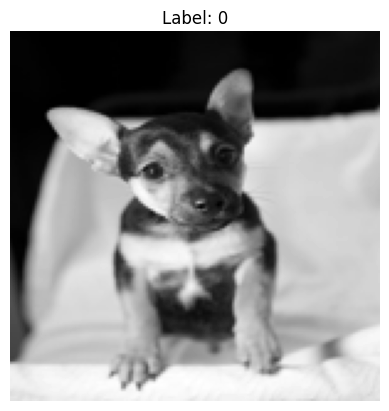

In [17]:
image, label = train_data[5]
plt.imshow(image, cmap='gray')
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()

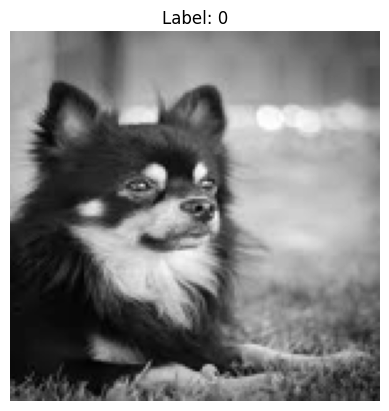

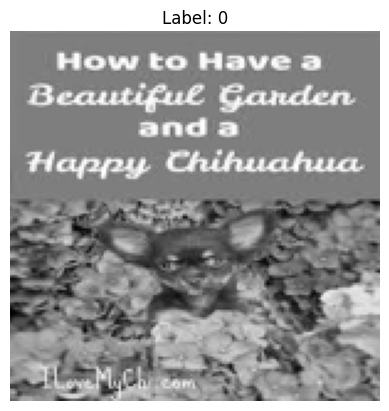

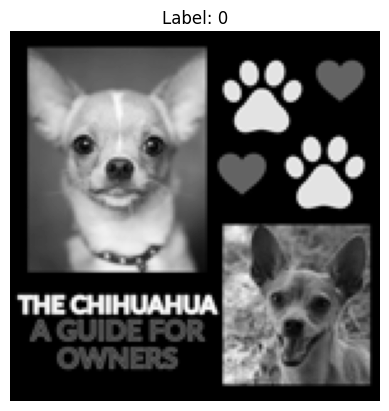

In [18]:
for i in range(3):
    image, label = train_data[i]
    plt.imshow(image, cmap='gray')
    plt.title(f"Label: {label}")
    plt.axis('off')
    plt.show()

In [19]:
random.shuffle(train_data)
random.shuffle(val_data)
random.shuffle(test_data)

Convert to NumPy arrays and normalize the pixel values to range [0, 1]

In [20]:
X_train = []
y_train = []

for image, label in train_data:
    X_train.append(image)
    y_train.append(label)
X_train = np.array(X_train).reshape(-1, 150, 150, 1)
y_train = np.array(y_train)

In [21]:
X_val = []
y_val = []

for image, label in val_data:
    X_val.append(image)
    y_val.append(label)
X_val = np.array(X_val).reshape(-1, 150, 150, 1)
y_val = np.array(y_val)

In [22]:
X_test = []
y_test = []

for image, label in test_data:
    X_test.append(image)
    y_test.append(label)
X_test = np.array(X_test).reshape(-1, 150, 150, 1)
y_test = np.array(y_test)

In [23]:
X_train = X_train / 255
X_val = X_val / 255
X_test = X_test / 255

In [24]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(4733, 150, 150, 1)
(4733,)
(591, 150, 150, 1)
(591,)
(593, 150, 150, 1)
(593,)


Now we start building the models

## First Model

We build the first base architecture just to see how it behaves

In [32]:
custom_seed_set()

model1 = Sequential([
    keras.layers.Input(shape=(150, 150, 1)),
    keras.layers.AveragePooling2D(2),
    
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation = 'relu'),
    keras.layers.Dense(1, activation = 'sigmoid')
])

model1.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history1 = model1.fit(X_train, y_train, epochs = 20, batch_size = 32, validation_data = (X_val, y_val))
history1

Epoch 1/20
 64/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5483 - loss: 1.1346

I0000 00:00:1716470919.175157     232 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


148/148 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.5476 - loss: 0.9215 - val_accuracy: 0.5465 - val_loss: 0.6768
Epoch 2/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5717 - loss: 0.6689 - val_accuracy: 0.6108 - val_loss: 0.6443
Epoch 3/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6250 - loss: 0.6425 - val_accuracy: 0.6261 - val_loss: 0.6379
Epoch 4/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6482 - loss: 0.6271 - val_accuracy: 0.6362 - val_loss: 0.6278
Epoch 5/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6673 - loss: 0.6153 - val_accuracy: 0.6362 - val_loss: 0.6269
Epoch 6/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6741 - loss: 0.6077 - val_accuracy: 0.6430 - val_loss: 0.6265
Epoch 7/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6803 - loss: 0.6032 - val_accuracy: 0.6430 - val_loss: 0.6253
Epoch 8/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6806 - loss: 0.5985 - val_accuracy: 0.6396 - val

In [33]:
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ average_pooling2d               │ (None, 75, 75, 1)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 5625)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       360,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,080,389 (4.12 MB)

 Trainable params: 360,129 (1.37 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 720,260 (2.75 MB)

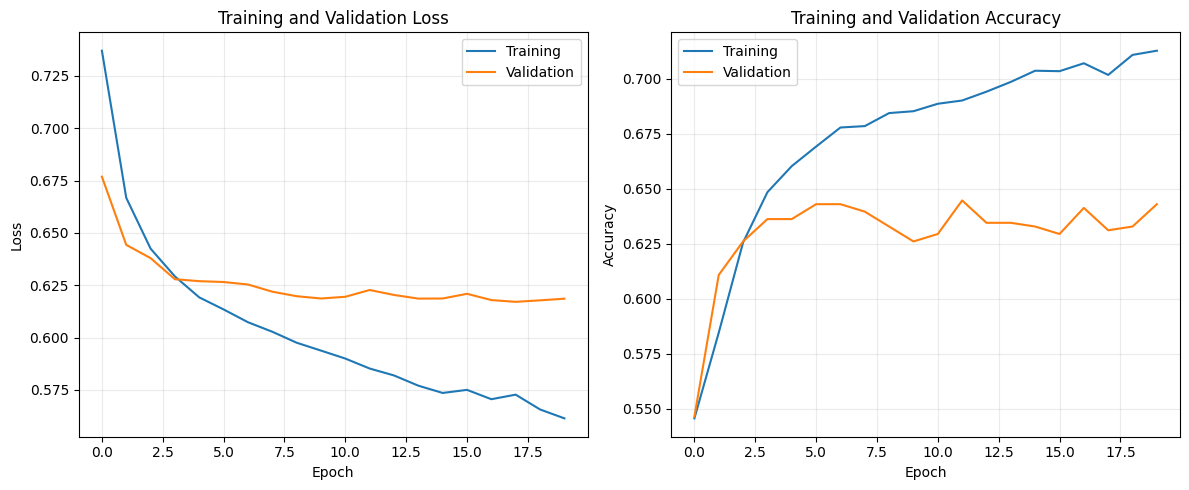

In [34]:
performance(history1)

We can see how the Validation Loss and Accuracy are fluctuating a lot, plus the reduction of the training loss and the increasing of the validation loss indicate a strong overfitting

In [35]:
loss, accuracy = model1.evaluate(X_test, y_test, verbose=2)

19/19 - 0s - 14ms/step - accuracy: 0.6509 - loss: 0.6028


Starting from the base architecture let's try to increase the performance of the model modifying the architecture. Let's add a Convolutional layer, a MaxPooling layer (instead of AveragePooling) and a Dropout layer with prob 0.5. Those (overall Dropout) should help reduce the overfitting. Plus we increase the number of epochs to 40.

In [32]:
custom_seed_set()

model1_2 = Sequential([
    keras.layers.Input(shape=(150, 150, 1)),
    keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
    keras.layers.MaxPooling2D((3, 3)),
    
    keras.layers.Flatten(),

    keras.layers.Dense(64, activation = 'relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation = 'sigmoid')
])

model1_2.compile(loss = 'binary_crossentropy',
               optimizer = 'adam',
               metrics = ['accuracy'])

In [33]:
history1_2 = model1_2.fit(X_train, y_train, epochs = 40, batch_size = 32, validation_data = (X_val, y_val))
history1_2

Epoch 1/40
148/148 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.5667 - loss: 1.2697 - val_accuracy: 0.7327 - val_loss: 0.5661
Epoch 2/40
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6792 - loss: 0.5876 - val_accuracy: 0.7462 - val_loss: 0.5743
Epoch 3/40
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7083 - loss: 0.5438 - val_accuracy: 0.7953 - val_loss: 0.5001
Epoch 4/40
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7253 - loss: 0.5102 - val_accuracy: 0.7919 - val_loss: 0.4799
Epoch 5/40
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7515 - loss: 0.4685 - val_accuracy: 0.7885 - val_loss: 0.4585
Epoch 6/40
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7348 - loss: 0.4735 - val_accuracy: 0.7953 - val_loss: 0.4344
Epoch 7/40
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7719 - loss: 0.4220 - val_accuracy: 0.8190 - val_loss: 0.4138
Epoch 8/40
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7804 - loss: 0.3977 - val_accurac

We can see that adding those 2 convolutional layers made the situation worse. Let's try to change the architectures and the filters in the Second model

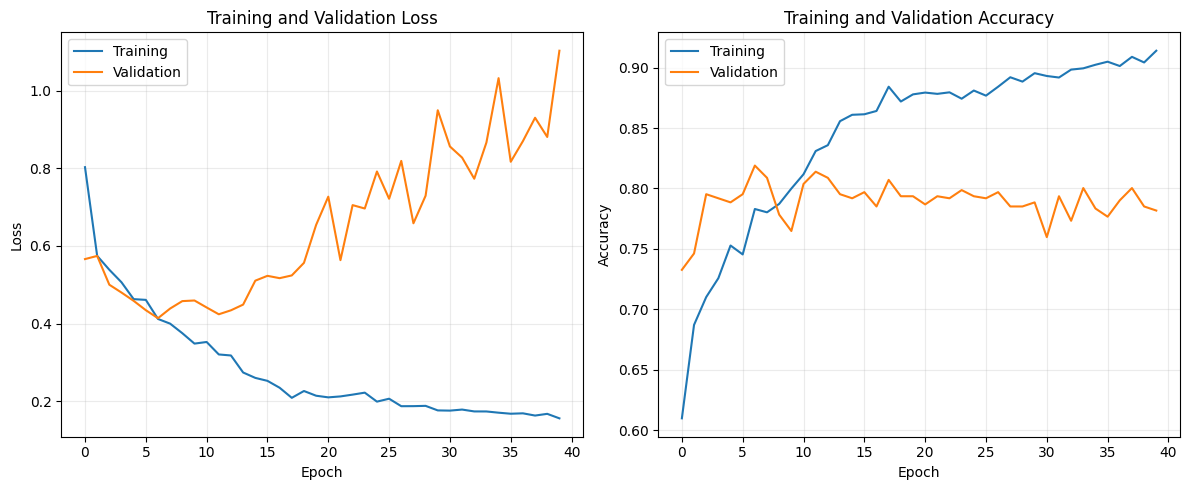

In [34]:
performance(history1_2)

In [35]:
loss, accuracy = model1_2.evaluate(X_test, y_test)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8127 - loss: 0.9263


## Second Model

Let's add some Convolutional and Pooling layers and see whether the situation gets better (shuffling the samples too) and reduce the number of epochs.

In [36]:
custom_seed_set()

model2 = Sequential([
    keras.layers.Input(shape=(150, 150, 1)),
    keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
    keras.layers.MaxPooling2D((3,3)),

    keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    keras.layers.MaxPooling2D((3,3)),
    
    keras.layers.Dropout(0.5),

    keras.layers.Flatten(),
    keras.layers.Dense(64, activation = 'relu'),
    keras.layers.Dense(1, activation = 'sigmoid')
])

model2.compile(loss = 'binary_crossentropy',
               optimizer = 'adam',
               metrics = ['accuracy'])
model2.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 148, 148, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 49, 49, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 47, 47, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 7200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │       460,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 480,033 (1.83 MB)

 Trainable params: 480,033 (1.83 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
history2 = model2.fit(X_train, y_train, batch_size = 32, epochs = 40, validation_data = (X_val, y_val), shuffle = True)
history2

Epoch 1/40
148/148 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - accuracy: 0.5877 - loss: 0.6510 - val_accuracy: 0.7479 - val_loss: 0.5187
Epoch 2/40
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7606 - loss: 0.5106 - val_accuracy: 0.7614 - val_loss: 0.4809
Epoch 3/40
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8020 - loss: 0.4415 - val_accuracy: 0.7885 - val_loss: 0.4386
Epoch 4/40
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8239 - loss: 0.3859 - val_accuracy: 0.8139 - val_loss: 0.4159
Epoch 5/40
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8361 - loss: 0.3748 - val_accuracy: 0.7834 - val_loss: 0.4449
Epoch 6/40
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8391 - loss: 0.3612 - val_accuracy: 0.8071 - val_loss: 0.4180
Epoch 7/40
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8559 - loss: 0.3312 - val_accuracy: 0.8613 - val_loss: 0.3520
Epoch 8/40
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8579 - loss: 0.3199 - val_accuracy: 0

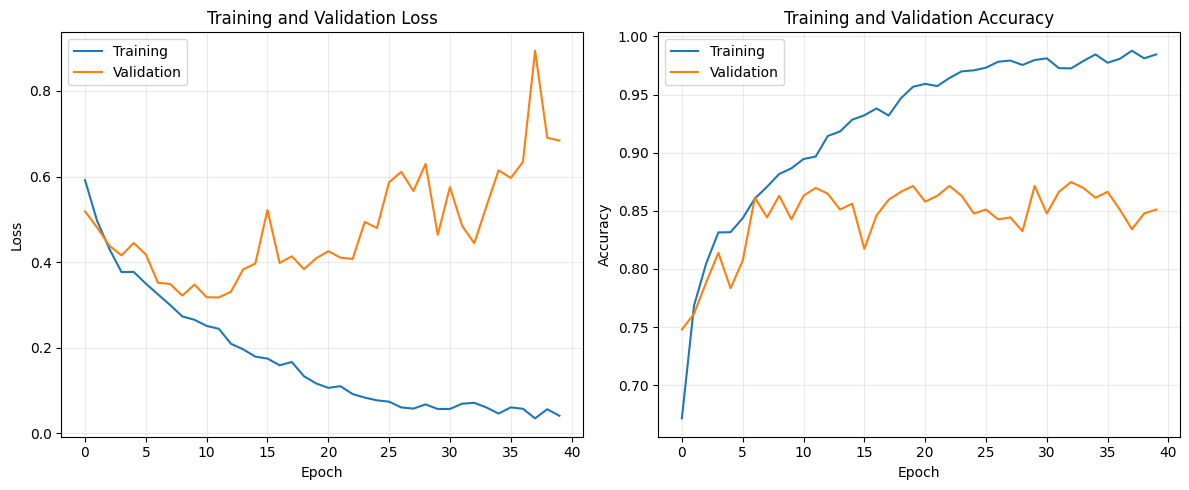

In [38]:
performance(history2)

In [39]:
loss, accuracy = model2.evaluate(X_test, y_test)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8254 - loss: 0.7162


Let's try to add one Convolutional and one Pooling layers and change some filters 

In [44]:
#let's try to put some more layers
custom_seed_set()

model2_1 = Sequential([
    keras.layers.Input(shape=(150, 150, 1)),
    keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
    keras.layers.MaxPooling2D((3,3)),

    keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    keras.layers.MaxPooling2D((3,3)),

    keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    keras.layers.MaxPooling2D((3,3)),
    
    keras.layers.Dropout(0.5),

    keras.layers.Flatten(),

    keras.layers.Dense(64, activation = 'relu'),
    keras.layers.Dense(1, activation = 'sigmoid')
])

model2_1.compile(loss = 'binary_crossentropy',
               optimizer = 'adam',
               metrics = ['accuracy'])
model2_1.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 148, 148, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 49, 49, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 47, 47, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 13, 13, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,249 (239.25 KB)

 Trainable params: 61,249 (239.25 KB)

 Non-trainable params: 0 (0.00 B)

In [45]:
history2_1 = model2_1.fit(X_train, y_train, batch_size = 32, epochs = 40, validation_data = (X_val, y_val), shuffle = True)
history2_1

Epoch 1/40
148/148 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.6006 - loss: 0.6598 - val_accuracy: 0.7851 - val_loss: 0.4924
Epoch 2/40
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7764 - loss: 0.4845 - val_accuracy: 0.8156 - val_loss: 0.4278
Epoch 3/40
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8059 - loss: 0.4318 - val_accuracy: 0.8206 - val_loss: 0.4194
Epoch 4/40
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8160 - loss: 0.4071 - val_accuracy: 0.8206 - val_loss: 0.3788
Epoch 5/40
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8203 - loss: 0.3921 - val_accuracy: 0.8409 - val_loss: 0.3524
Epoch 6/40
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8291 - loss: 0.3777 - val_accuracy: 0.8629 - val_loss: 0.3212
Epoch 7/40
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8431 - loss: 0.3485 - val_accuracy: 0.8528 - val_loss: 0.3458
Epoch 8/40
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8607 - loss: 0.3251 - val_accuracy: 0

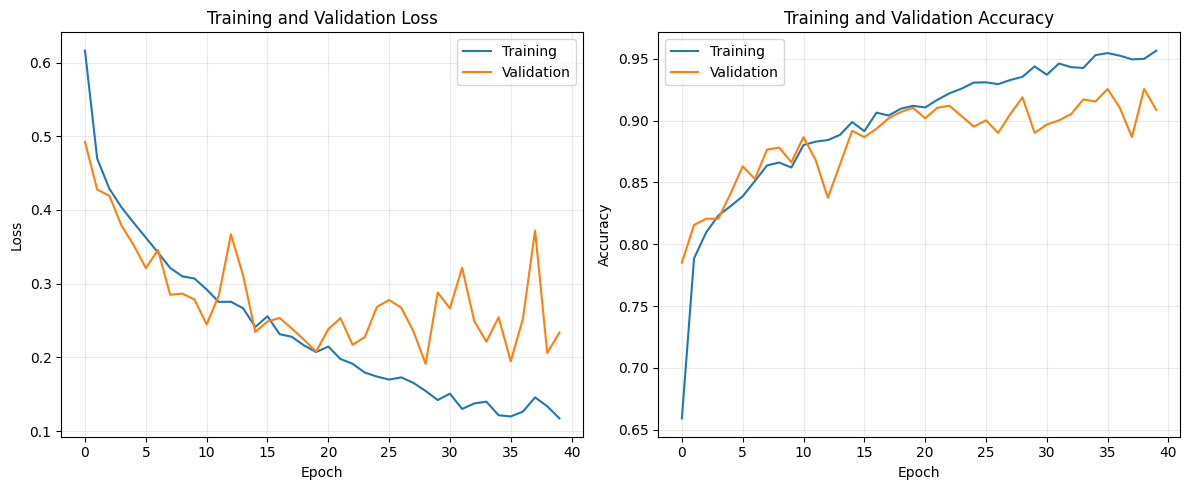

In [46]:
performance(history2_1)

We can see that the model performs better now even though the validation parameters (loss and accuracy) are volatile. 

In [47]:
loss, accuracy = model2_1.evaluate(X_test, y_test, verbose = 2)

19/19 - 0s - 22ms/step - accuracy: 0.9292 - loss: 0.2163


Let's try to insert EarlyStopping and change some parameters

In [24]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler

In [108]:
def call_backs(patience):
    return [
        EarlyStopping(
            monitor='val_loss',
            patience=patience,
            verbose=1,
            restore_best_weights=True
        )
    ]

In [54]:
custom_seed_set()

model2_3 = Sequential([
    keras.layers.Input(shape=(150, 150, 1)),
    keras.layers.Conv2D(64, (2, 2), activation = 'relu'),
    keras.layers.AveragePooling2D((2,2)), 
    keras.layers.Dropout(0.3),

    keras.layers.Conv2D(64, (2, 2), activation = 'relu'),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Dropout(0.3),

    keras.layers.Conv2D(256, (3, 3), activation = 'relu'),
    keras.layers.AveragePooling2D((3,3)), #Avg
    keras.layers.Dropout(0.5),
    
    keras.layers.Flatten(),

    keras.layers.Dense(64, activation = 'relu'), 
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1, activation = 'sigmoid') 
])

model2_3.compile(loss = 'binary_crossentropy',
               optimizer = 'adam',
               metrics = ['accuracy'])
model2_3.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 149, 149, 64)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 74, 74, 64)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 74, 74, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 73, 73, 64)     │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 34, 34, 256)    │       147,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_2             │ (None, 11, 11, 256)    │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 11, 11, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │     1,982,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,147,073 (8.19 MB)

 Trainable params: 2,147,073 (8.19 MB)

 Non-trainable params: 0 (0.00 B)

In [55]:
history2_3 = model2_3.fit(X_train, y_train, 
                          batch_size = 32, 
                          epochs = 60, 
                          validation_data = (X_val, y_val), 
                          shuffle = True, 
                          callbacks = call_backs(8))
history2_3 

Epoch 1/60
148/148 ━━━━━━━━━━━━━━━━━━━━ 20s 75ms/step - accuracy: 0.5481 - loss: 0.7092 - val_accuracy: 0.6294 - val_loss: 0.6670
Epoch 2/60
148/148 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.6380 - loss: 0.6348 - val_accuracy: 0.5990 - val_loss: 0.6867
Epoch 3/60
148/148 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.6976 - loss: 0.5793 - val_accuracy: 0.7445 - val_loss: 0.5267
Epoch 4/60
148/148 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.7664 - loss: 0.4932 - val_accuracy: 0.7699 - val_loss: 0.4693
Epoch 5/60
148/148 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.7863 - loss: 0.4733 - val_accuracy: 0.7902 - val_loss: 0.4492
Epoch 6/60
148/148 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.7963 - loss: 0.4519 - val_accuracy: 0.7766 - val_loss: 0.4580
Epoch 7/60
148/148 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.8076 - loss: 0.4377 - val_accuracy: 0.7597 - val_loss: 0.4768
Epoch 8/60
148/148 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.8040 - loss: 0.4319 - val_acc

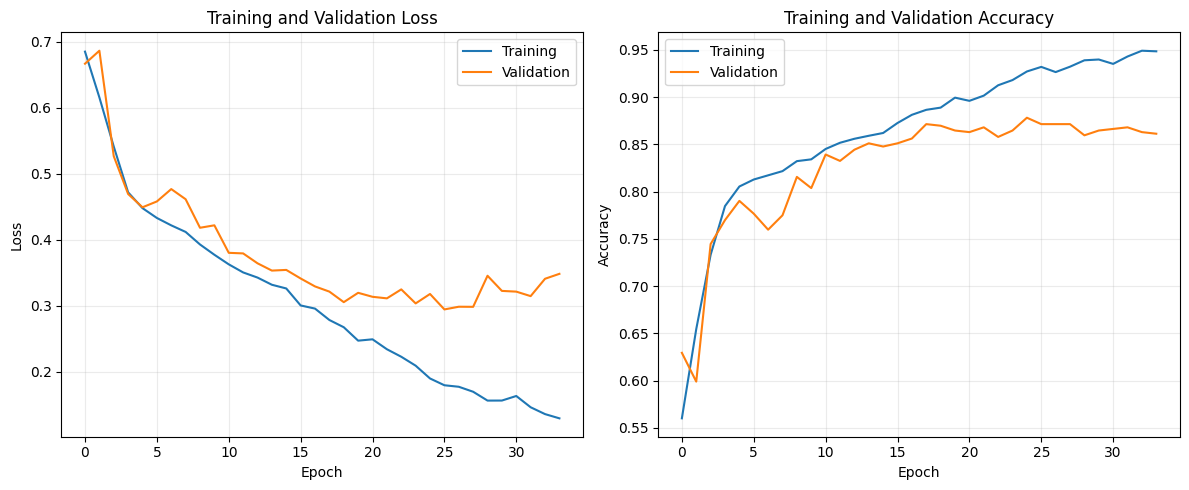

In [56]:
performance(history2_3)

In [57]:
loss, accuracy = model2_3.evaluate(X_test, y_test, verbose=2)

19/19 - 1s - 47ms/step - accuracy: 0.9123 - loss: 0.2530


## Model 3

We are on the right way. Let's try to insert data augmentation, add more layers and change the hyperparameters.


In [62]:
custom_seed_set()

model3_2 = Sequential([
    keras.layers.Input(shape=(150, 150, 1)),
    keras.layers.Conv2D(128, (2, 2), activation = 'relu'),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Dropout(0.5),

    keras.layers.Conv2D(128, (2, 2), activation = 'relu'),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Dropout(0.5),
    
    keras.layers.Conv2D(256, (2, 2), activation = 'relu'),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Dropout(0.6),

    keras.layers.Conv2D(512, (2, 2), activation = 'relu'),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Dropout(0.7),
    
    keras.layers.Flatten(),

    keras.layers.Dense(256, activation = 'relu'),
    keras.layers.Dropout(0.6),
    keras.layers.Dense(1, activation = 'sigmoid')
])

model3_2.compile(loss = 'binary_crossentropy',
               optimizer = 'adam',
               metrics = ['accuracy'])
model3_2.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (None, 149, 149, 128)  │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 74, 74, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 74, 74, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 73, 73, 128)    │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 36, 36, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 36, 36, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 35, 35, 256)    │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 17, 17, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 17, 17, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 16, 16, 512)    │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,111,553 (34.76 MB)

 Trainable params: 9,111,553 (34.76 MB)

 Non-trainable params: 0 (0.00 B)

In [63]:
history3_2 = model3_2.fit(X_train, y_train, 
                          batch_size = 32, 
                          epochs = 60, 
                          validation_data = (X_val, y_val), 
                          shuffle = True, 
                          callbacks = call_backs(9))
history3_2

Epoch 1/60
148/148 ━━━━━━━━━━━━━━━━━━━━ 24s 96ms/step - accuracy: 0.5401 - loss: 0.8839 - val_accuracy: 0.4585 - val_loss: 0.6937
Epoch 2/60
148/148 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.5250 - loss: 0.6910 - val_accuracy: 0.5364 - val_loss: 0.6905
Epoch 3/60
148/148 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.5811 - loss: 0.6610 - val_accuracy: 0.6024 - val_loss: 0.6684
Epoch 4/60
148/148 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.6392 - loss: 0.6192 - val_accuracy: 0.7766 - val_loss: 0.5284
Epoch 5/60
148/148 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.7688 - loss: 0.5159 - val_accuracy: 0.7986 - val_loss: 0.4760
Epoch 6/60
148/148 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.7827 - loss: 0.4645 - val_accuracy: 0.8206 - val_loss: 0.4231
Epoch 7/60
148/148 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.7805 - loss: 0.4693 - val_accuracy: 0.8190 - val_loss: 0.4275
Epoch 8/60
148/148 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.7844 - loss: 0.4683 - val_acc

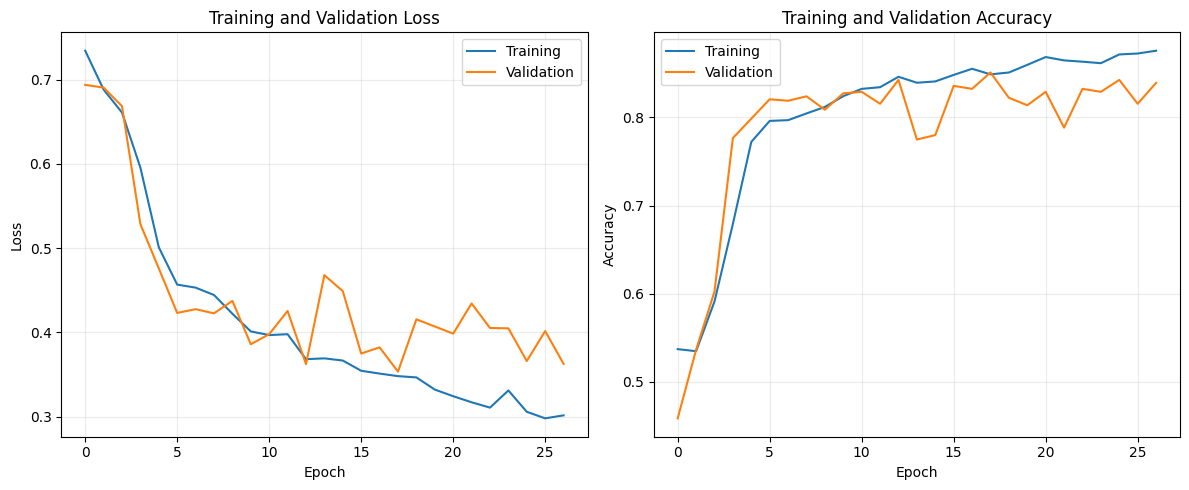

In [64]:
performance(history3_2)

In [65]:
loss, accuracy = model3_2.evaluate(X_test, y_test, verbose=2)

19/19 - 1s - 27ms/step - accuracy: 0.8634 - loss: 0.3189


We now introduce data augmentation and EarlyStopping

## Model 3 - Data Augmentation 

In [83]:
train_datagen = ImageDataGenerator(rescale=1./255)

In [84]:
train_gen = train_datagen.flow_from_directory(
    train_path,
    target_size=(150, 150),
    color_mode='grayscale',
    batch_size=32,
    class_mode='binary'
)

Found 4733 images belonging to 2 classes.


In [85]:
val_datagen = ImageDataGenerator(rescale=1./255)

In [86]:
val_gen = val_datagen.flow_from_directory(
    val_path,
    target_size=(150, 150),
    color_mode='grayscale',
    batch_size=32,
    class_mode='binary'
)

Found 591 images belonging to 2 classes.


In [87]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [88]:
test_gen = test_datagen.flow_from_directory(
    test_path,
    target_size=(150, 150),
    color_mode='grayscale',
    batch_size=32,
    class_mode='binary'
)

Found 593 images belonging to 2 classes.


In [100]:
def call_backs(patience):
    return [
        EarlyStopping(patience=patience, restore_best_weights=True),
        ReduceLROnPlateau(patience=patience//3, factor=0.2),
        ModelCheckpoint('best_model.keras', save_best_only=True)
    ]

def lr_scheduler(epoch, lr):
    if epoch > 10:
        return lr * 0.1
    return lr

In [111]:
data_augmentation3_4 = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.01),
    RandomZoom(0.01)
])


In [109]:
custom_seed_set()

model3_4 = Sequential([
    keras.layers.Input(shape=(150, 150, 1)),
    data_augmentation3_4,
    
    keras.layers.Conv2D(32, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.2),

    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.3),

    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.4),
    
    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.4),

    keras.layers.Flatten(),

    keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid')
])

In [110]:
from tensorflow.keras.optimizers import Adam

initial_lr = 0.001
lr_schedule = ExponentialDecay(
    initial_learning_rate=initial_lr,
    decay_steps=10000,
    decay_rate=0.9,
    staircase=True)

model3_4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), loss='binary_crossentropy', metrics=['accuracy'])

In [85]:
history3_4 = model3_4.fit(
    train_gen,
    epochs=50,
    batch_size = 64,
    validation_data=val_gen,
    shuffle = True,
    callbacks = call_backs(9).append(LearningRateScheduler(lr_scheduler))
)

Epoch 1/50


2024-05-21 20:38:14.504839: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_14_1/dropout_35_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


148/148 ━━━━━━━━━━━━━━━━━━━━ 30s 179ms/step - accuracy: 0.5397 - loss: 2.3898 - val_accuracy: 0.5415 - val_loss: 0.7128
Epoch 2/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 26s 169ms/step - accuracy: 0.5443 - loss: 0.7002 - val_accuracy: 0.6667 - val_loss: 0.6659
Epoch 3/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 26s 170ms/step - accuracy: 0.6539 - loss: 0.6518 - val_accuracy: 0.7343 - val_loss: 0.5925
Epoch 4/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 26s 170ms/step - accuracy: 0.7243 - loss: 0.5889 - val_accuracy: 0.7259 - val_loss: 0.5613
Epoch 5/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 27s 172ms/step - accuracy: 0.7374 - loss: 0.5565 - val_accuracy: 0.6785 - val_loss: 0.6383
Epoch 6/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 27s 175ms/step - accuracy: 0.7863 - loss: 0.4948 - val_accuracy: 0.7716 - val_loss: 0.5009
Epoch 7/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 27s 175ms/step - accuracy: 0.7902 - loss: 0.5000 - val_accuracy: 0.7885 - val_loss: 0.4921
Epoch 8/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 27s 175ms/step - accuracy: 0.7942 - loss: 0.4791 - val

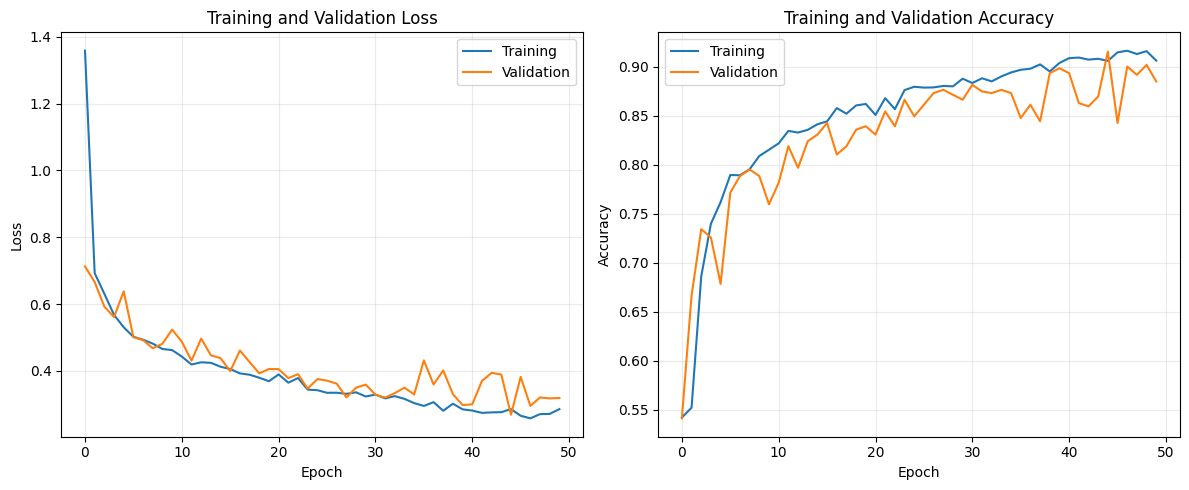

In [86]:
performance(history3_4)

In [87]:
loss, accuracy = model3_4.evaluate(test_gen, verbose=2)

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


19/19 - 3s - 160ms/step - accuracy: 0.8921 - loss: 0.2978


# Hyperparameter Tuning 

In [33]:
import keras_tuner as kt

In [34]:
#X_train = X_train.astype('float32') / 255.0

In [35]:
#X_val = X_val.astype('float32') / 255

In [36]:
def model_builder(hp):
  model = keras.Sequential()
    
  #tune for the first layer 
  #Conv2D  
  hp_filters1 = hp.Int('filters1', min_value = 32, max_value = 128, step = 16)

  model.add(keras.layers.Conv2D(filters=hp_filters1, kernel_size=(2, 2), activation='relu', input_shape=(150, 150, 1)))
  model.add(keras.layers.MaxPooling2D((2,2)))
  #Dropout   
  hp_rate1 = hp.Float('rate1', min_value = 0.3, max_value = 0.7, step = 0.1)
  model.add(keras.layers.Dropout(rate=hp_rate1))
    
  #tune for the second layer   
  #Conv2D   
  hp_filters2 = hp.Int('filters2', min_value = 32, max_value = 128, step = 16)

  model.add(keras.layers.Conv2D(filters=hp_filters2, kernel_size=(2, 2), activation='relu'))
  model.add(keras.layers.MaxPooling2D((2,2)))
  #Dropout  
  hp_rate2 = hp.Float('rate2', min_value = 0.3, max_value = 0.7, step = 0.1)
  model.add(keras.layers.Dropout(rate=hp_rate2))

  #tune for the third layer 
  #Conv2D   
  hp_filters3 = hp.Int('filters3', min_value = 32, max_value = 128, step = 16)

  model.add(keras.layers.Conv2D(filters=hp_filters3, kernel_size=(2, 2), activation='relu'))
  model.add(keras.layers.MaxPooling2D((2,2)))
  #Dropout  
  hp_rate3 = hp.Float('rate3', min_value = 0.3, max_value = 0.7, step = 0.1)
  model.add(keras.layers.Dropout(rate=hp_rate3))  
    
  hp_filters4 = hp.Int('filters4', min_value = 32, max_value = 128, step = 16)

  model.add(keras.layers.Conv2D(filters=hp_filters4, kernel_size=(2, 2), activation='relu'))
  model.add(keras.layers.MaxPooling2D((2,2)))
  #Dropout  
  hp_rate4 = hp.Float('rate4', min_value = 0.3, max_value = 0.7, step = 0.1)
  model.add(keras.layers.Dropout(rate=hp_rate4))  

  model.add(Flatten())    
    
  #Dense layers  
  hp_units1 = hp.Int('units1', min_value=32, max_value=256, step=32)
  model.add(keras.layers.Dense(units=hp_units1, activation='relu'))
  hp_units2 = hp.Int('units2', min_value=32, max_value=64, step=16)
  model.add(keras.layers.Dense(units=hp_units2, activation='relu'))  
  model.add(keras.layers.Dense(1, activation='sigmoid'))

  #Tune the learning rate for the optimizer
  #value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss='binary_crossentropy',
                metrics=['accuracy'])

  return model

In [37]:
tuner = kt.Hyperband(model_builder,
                     objective='val_loss',
                     max_epochs=50,
                     factor=3,
                     directory='/kaggle/working/',
                     project_name='intro_to_k')

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Note that Hyperband will dynamically allocate more or fewer epochs to different configurations based on their performance.

In [41]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6)

In [39]:
tuner.search(train_gen, epochs=50, validation_data=val_gen, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 90 Complete [00h 04m 11s]
val_loss: 0.6897492408752441

Best val_loss So Far: 0.26756128668785095
Total elapsed time: 04h 44m 12s


In [40]:
print(f"""
The hyperparameter search is complete. The optimal number of filters in the first conv layer is {best_hps.get('filters1')},
the optimal number of filters in the second conv layer is {best_hps.get('filters2')},
the optimal number of filters in the third conv layer is {best_hps.get('filters3')},
the optimal dropout rate for the first dropout layer is {best_hps.get('rate1')},
the optimal dropout rate for the second dropout layer is {best_hps.get('rate2')},
the optimal dropout rate for the third dropout layer is {best_hps.get('rate3')},
the optimal number of units in the first dense layer is {best_hps.get('units1')},
the optimal number of units in the second dense layer is {best_hps.get('units2')},
and the optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
""")


The hyperparameter search is complete. The optimal number of filters in the first conv layer is 128,
the optimal number of filters in the second conv layer is 96,
the optimal number of filters in the third conv layer is 32,
the optimal dropout rate for the first dropout layer is 0.5,
the optimal dropout rate for the second dropout layer is 0.3,
the optimal dropout rate for the third dropout layer is 0.3,
the optimal number of units in the first dense layer is 192,
the optimal number of units in the second dense layer is 32,
and the optimal learning rate for the optimizer is 0.001.



In [52]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
history_hp1 = hypermodel.fit(train_gen, epochs=60, validation_data=val_gen, callbacks=[stop_early])

Epoch 1/60
148/148 ━━━━━━━━━━━━━━━━━━━━ 49s 264ms/step - accuracy: 0.5380 - loss: 0.6898 - val_accuracy: 0.6481 - val_loss: 0.6433
Epoch 2/60
148/148 ━━━━━━━━━━━━━━━━━━━━ 29s 187ms/step - accuracy: 0.6749 - loss: 0.6118 - val_accuracy: 0.7614 - val_loss: 0.5746
Epoch 3/60
148/148 ━━━━━━━━━━━━━━━━━━━━ 29s 190ms/step - accuracy: 0.7427 - loss: 0.5353 - val_accuracy: 0.7750 - val_loss: 0.5106
Epoch 4/60
148/148 ━━━━━━━━━━━━━━━━━━━━ 29s 190ms/step - accuracy: 0.7787 - loss: 0.4741 - val_accuracy: 0.7783 - val_loss: 0.4845
Epoch 5/60
148/148 ━━━━━━━━━━━━━━━━━━━━ 29s 189ms/step - accuracy: 0.7923 - loss: 0.4498 - val_accuracy: 0.8206 - val_loss: 0.4577
Epoch 6/60
148/148 ━━━━━━━━━━━━━━━━━━━━ 30s 193ms/step - accuracy: 0.8094 - loss: 0.4330 - val_accuracy: 0.8240 - val_loss: 0.4502
Epoch 7/60
148/148 ━━━━━━━━━━━━━━━━━━━━ 29s 187ms/step - accuracy: 0.8063 - loss: 0.4227 - val_accuracy: 0.8291 - val_loss: 0.4380
Epoch 8/60
148/148 ━━━━━━━━━━━━━━━━━━━━ 30s 193ms/step - accuracy: 0.8151 - loss: 0

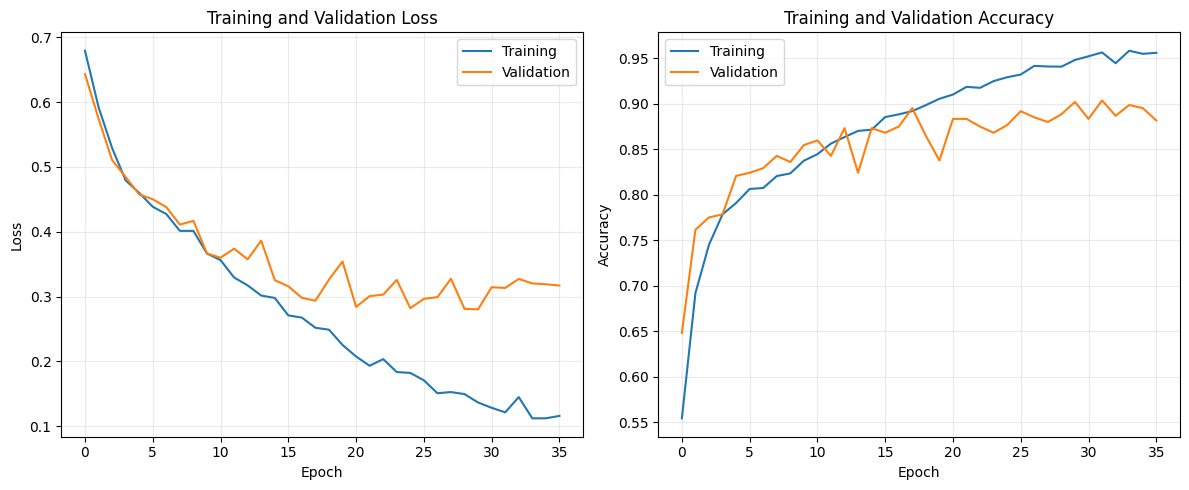

In [53]:
performance(history_hp1)

In [54]:
loss, accuracy = hypermodel.evaluate(test_gen)

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 171ms/step - accuracy: 0.8320 - loss: 0.4052


# 5-Fold Cross Validation 

We implement it with zero-one loss

In [112]:
from sklearn.model_selection import KFold

In [ ]:
def call_backs(patience):
    return [
        EarlyStopping(
            monitor='val_loss',
            patience=patience,
            verbose=1,
            restore_best_weights=True
        )
    ]

In [113]:
def zero_one_loss(y_true, y_pred):
    assert len(y_true) == len(y_pred)
    return sum(y_true != y_pred) / len(y_true)

In [114]:
inputs = np.concatenate((X_train, X_test), axis=0)
targets = np.concatenate((y_train, y_test), axis=0)

num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True)

5-fold cross validation to the final third model

In [115]:
accuracy_fold = [] 
loss_fold = []
zero_one_loss_fold = []
histories = []

fold_no = 1
for train, test in kfold.split(inputs, targets):
    print(f'Training fold {fold_no}...')
    history = model3_4.fit(inputs[train], 
                        targets[train],
                        epochs=60,
                        batch_size=64,
                        verbose=1,
                        validation_data=(X_val, y_val),
                        callbacks=call_backs(6))
    
    histories.append(history)
    
    y_pred = model3_4.predict(inputs[test], batch_size=32)
    y_pred = (y_pred > 0.5).astype('int32').flatten()
    
    scores = model3_4.evaluate(inputs[test], targets[test], verbose=1)
    print(f'Score for fold {fold_no}: Loss = {scores[0]}, Accuracy = {scores[1]}')
    zero_one_loss_val = zero_one_loss(targets[test], y_pred)
    print(f'Score for fold {fold_no}: Zero-One Loss = {zero_one_loss_val}')
    
    zero_one_loss_fold.append(zero_one_loss_val)
    accuracy_fold.append(scores[1])
    loss_fold.append(scores[0])
    
    fold_no += 1

Training fold 1...
Epoch 1/60


2024-05-27 16:49:43.073630: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_11_1/dropout_25_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.5427 - loss: 3.0343 - val_accuracy: 0.5415 - val_loss: 0.7894
Epoch 2/60
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.5484 - loss: 0.7442 - val_accuracy: 0.6633 - val_loss: 0.6850
Epoch 3/60
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.6868 - loss: 0.6348 - val_accuracy: 0.7936 - val_loss: 0.5419
Epoch 4/60
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.7588 - loss: 0.5530 - val_accuracy: 0.7716 - val_loss: 0.5229
Epoch 5/60
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.7627 - loss: 0.5429 - val_accuracy: 0.7868 - val_loss: 0.5050
Epoch 6/60
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.7933 - loss: 0.4990 - val_accuracy: 0.8240 - val_loss: 0.4518
Epoch 7/60
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.8152 - loss: 0.4684 - val_accuracy: 0.8359 - val_loss: 0.4376
Epoch 8/60
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.8096 - loss: 0.4655 - val_accuracy: 0.8291 - val_loss: 0.

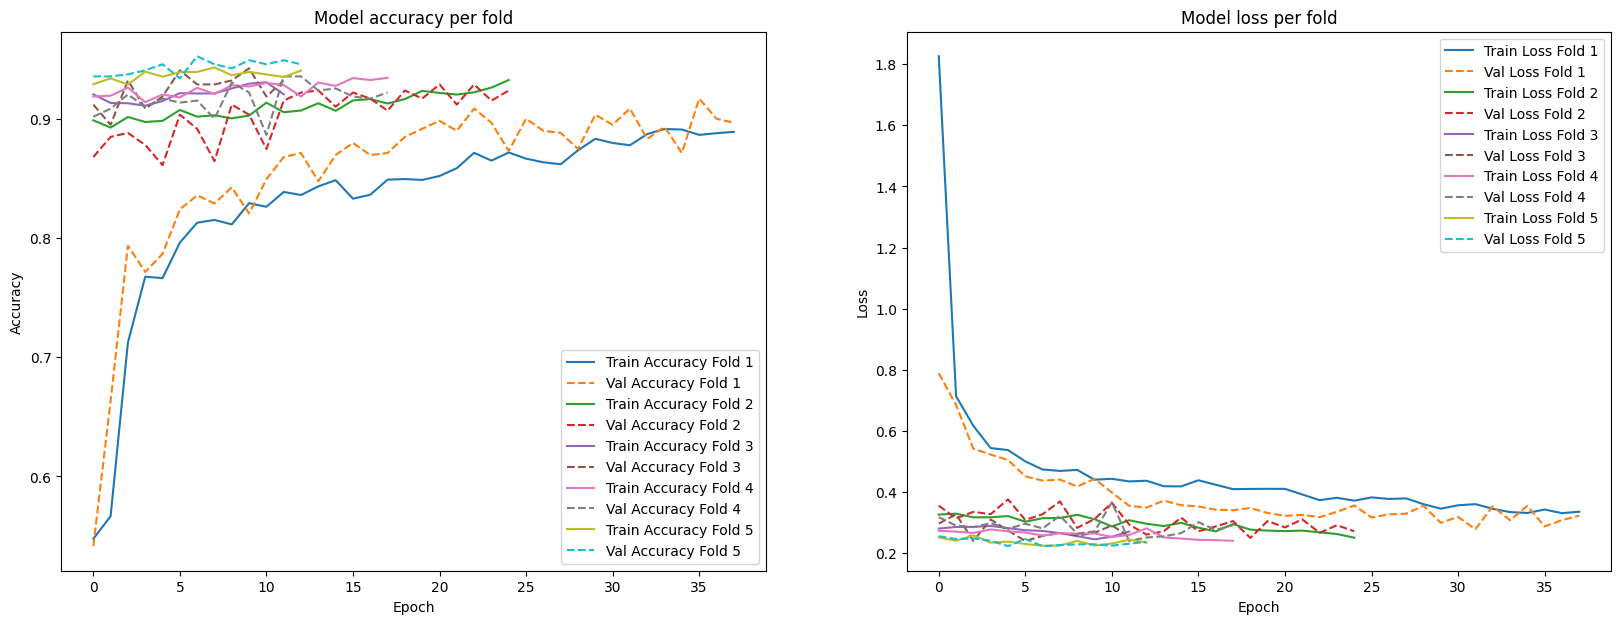

In [116]:
fig, ax = plt.subplots(1, 2, figsize=(20, 7))

for i, history in enumerate(histories):
    ax[1].plot(history.history['loss'], label=f'Train Loss Fold {i+1}')
    ax[1].plot(history.history['val_loss'], label=f'Val Loss Fold {i+1}', linestyle="--")
    ax[1].set_title('Model loss per fold')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(loc='upper right')

for i, history in enumerate(histories):
    ax[0].plot(history.history['accuracy'], label=f'Train Accuracy Fold {i+1}')
    ax[0].plot(history.history['val_accuracy'], label=f'Val Accuracy Fold {i+1}', linestyle="--")
    ax[0].set_title('Model accuracy per fold')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(loc='lower right')

plt.show()